# Predicting Forest Fires
### Course Assignment for ECON F241: Econometric Methods

<img src="https://upload.wikimedia.org/wikipedia/commons/d/d8/Deerfire_high_res_edit.jpg" />

## Objective

Forest fires help in the natural cycle of woods' growth and replenishment. They clear dead trees, leaves, and competing vegetation from the forest floor, so new plants can grow. Remove weak or disease-ridden trees, leaving more space and nutrients for stronger trees.

But when fires burn too hot and uncontrollable or when they’re in the “wildland-urban interface” (the places where woodlands and homes or other developed areas meet), they can be damaging and life threatning.

In this kernel, our aim is to predict the burned area (`area`) of forest fires. Based on the the spatial, temporal, and weather variables where the fire is spotted.

This prediction can be used for calculating the forces sent to the incident and deciding the urgency of the situation.

Information of Dataset For more information

1. FFMC - FFMC index from the FWI system: 18.7 to 96.20 
2. DMC - DMC index from the FWI system: 1.1 to 291.3 
3. DC - DC index from the FWI system: 7.9 to 860.6 
4. ISI - ISI index from the FWI system: 0.0 to 56.10 
5. temp - temperature in Celsius degrees: 2.2 to 33.30 
6. RH - relative humidity in %: 15.0 to 100 
7. wind - wind speed in km/h: 0.40 to 9.40 
8. rain - outside rain in mm/m2 : 0.0 to 6.4 
9. area - the burned area of the forest (in ha): 0.00 to 1090.84 (this output variable is very skewed towards 0.0, thus it may make sense to model with the logarithm transform).

### Model Notation and Assumptions

<img src="https://miro.medium.com/max/538/1*9i8CucipNQCVMM1d2nSYwQ.jpeg" />
where
<img src="https://miro.medium.com/max/700/1*Q3OpNCxNkOEWEJWH0y52yQ.jpeg" />

In order to “fit” a linear regression model, we establish certain assumptions about the random error that would ensure that we have a good approximation of the actual phenomena once these assumptions are applicable.
These assumptions are as follows:

<img src="https://miro.medium.com/max/700/1*33ygFMRN6ZdD-H71_E_4_Q.jpeg" />

In [1]:
target = 'area'

### Define the metrics

#### RMSE

RMSE is the most popular evaluation metric used in regression problems. It follows an assumption that error are unbiased and follow a normal distribution.

## Dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from scipy.stats import zscore
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split,KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
# from mlxtend.feature_selection import SequentialFeatureSelector as sfs
# from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings(action='ignore',message='^internal gelsd')

## Load and describe data

In [3]:
# file = 'forestfires.csv'
path = "../dataset/forestfires.csv"
df = pd.read_csv(path)

df.shape

(517, 9)

In [4]:
df.dtypes

FFMC (FFMC index from the FWI system)         float64
DMC (DMC index from the FWI system)           float64
DC ( DC index from the FWI system)            float64
ISI ( ISI index from the FWI system)          float64
temp (in degrees celsius)                     float64
RH (relative humidity in %)                     int64
wind (wind speed in kmph)                     float64
rain (outside rain in mm per square metre)    float64
area (burnt area of the forest in hectare)    float64
dtype: object

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
FFMC (FFMC index from the FWI system),517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC (DMC index from the FWI system),517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC ( DC index from the FWI system),517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI ( ISI index from the FWI system),517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp (in degrees celsius),517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH (relative humidity in %),517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind (wind speed in kmph),517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain (outside rain in mm per square metre),517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40
area (burnt area of the forest in hectare),517.0,12.847292,63.655818,0.0,0.0,0.52,6.57,1090.84


We can see 50% (the middle of the data) also called median of feature columns('DMC', 'ISI', 'RH', 'wind', 'rain', 'area') have higher mean value than median i.e data is right skewed. Among all feature columns, column: 'area' is highly skewed.

**How to handle right skewed data?**

Here data are right-skewed (clustered at lower values). We will perform operations like:- square root, cube root, logarithmic, etc. to transform the data. If the data are left-skewed (clustered at higher values). We will perform operations like:- cube, square, etc.



In [6]:
# Renaming the column names for our ease
df.rename(columns={'FFMC (FFMC index from the FWI system)': 'FFMC', 'DMC (DMC index from the FWI system)': 'DMC', 'DC ( DC index from the FWI system)':'DC','ISI ( ISI index from the FWI system)':'ISI', 'temp (in degrees celsius)':'temp','RH (relative humidity in %)':'RH', 'wind (wind speed in kmph)':'wind', 'rain (outside rain in mm per square metre)':'rain', 'area (burnt area of the forest in hectare)':'area'  }, inplace=True)

In [7]:
df.head(5)

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


### Missing value treatment

In [8]:
print("No. of missing values =",df.isna().sum().sum())

No. of missing values = 0


## Exploratory Data Analysis

We will try out the following analysis on our dataset

- Univariate
- Bivariate
- Multivariate

In [9]:
plt.rcParams["figure.figsize"] = 9,5

### Univariate analysis

Skew: 12.846933533934868
Kurtosis: 194.1407210942299


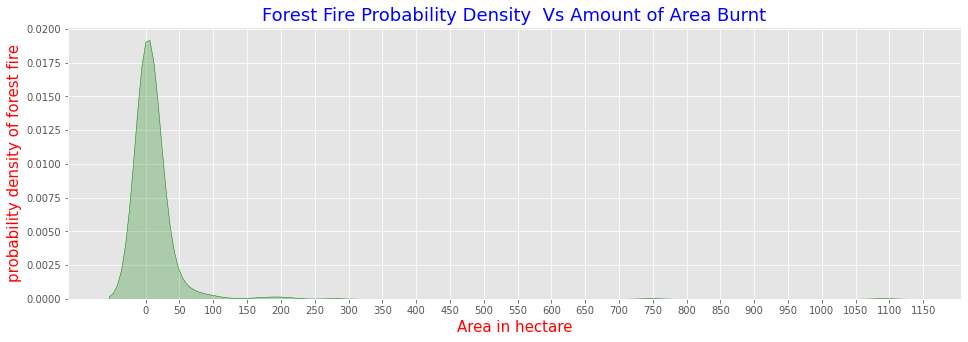

In [10]:
# Let's begin with target variable, 'area'
plt.figure(figsize=(16,5))
print("Skew: {}".format(df[target].skew()))
print("Kurtosis: {}".format(df[target].kurtosis()))
ax = sns.kdeplot(df[target],shade=True,color='g')
plt.xlabel('Area in hectare',color='red',fontsize=15)
plt.ylabel('probability density of forest fire',color='red',fontsize=15)
plt.title('Forest Fire Probability Density  Vs Amount of Area Burnt',color='blue',fontsize=18)
plt.xticks([i for i in range(0,1200,50)])
plt.show()

/home/thedhruvrawat/anaconda3/envs/dl/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


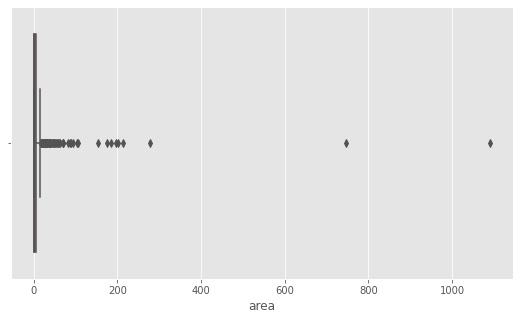

In [11]:
ax = sns.boxplot(df[target])

__Few observations:__

- The data is highly skewed with a value of +12.84 and huge kurtosis value of 194.

- It even tells you that majority of the forest fires do not cover a large area, most of the damaged area is under 50 hectares of land.

- We can apply tranformation to fix the skewnesss and kurtosis, however we will have to inverse transform before submitting the output.

- __Outlier Check__: There are 4 outlier instances in our area columns but the questions is should we drop it or not? (Will get back to this in the outlier treatment step)

In [12]:
# Outlier points
y_outliers = df[abs(zscore(df[target])) >= 3 ]
y_outliers

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
237,91.0,129.5,692.6,7.0,18.8,40,2.2,0.0,212.88
238,92.5,121.1,674.4,8.6,25.1,27,4.0,0.0,1090.84
415,94.8,222.4,698.6,13.9,27.5,27,4.9,0.0,746.28
479,89.2,103.9,431.6,6.4,22.6,57,4.9,0.0,278.53


### Independent columns

In [13]:
dfa = df.drop(columns=target)
num_columns = dfa.columns.tolist()

num_columns

['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

/home/thedhruvrawat/anaconda3/envs/dl/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:395: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
/home/thedhruvrawat/anaconda3/envs/dl/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:395: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
/home/thedhruvrawat/anaconda3/envs/dl/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:395: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
/home/thedhruvrawat/anaconda3/envs/dl/lib/python3.7/site-p

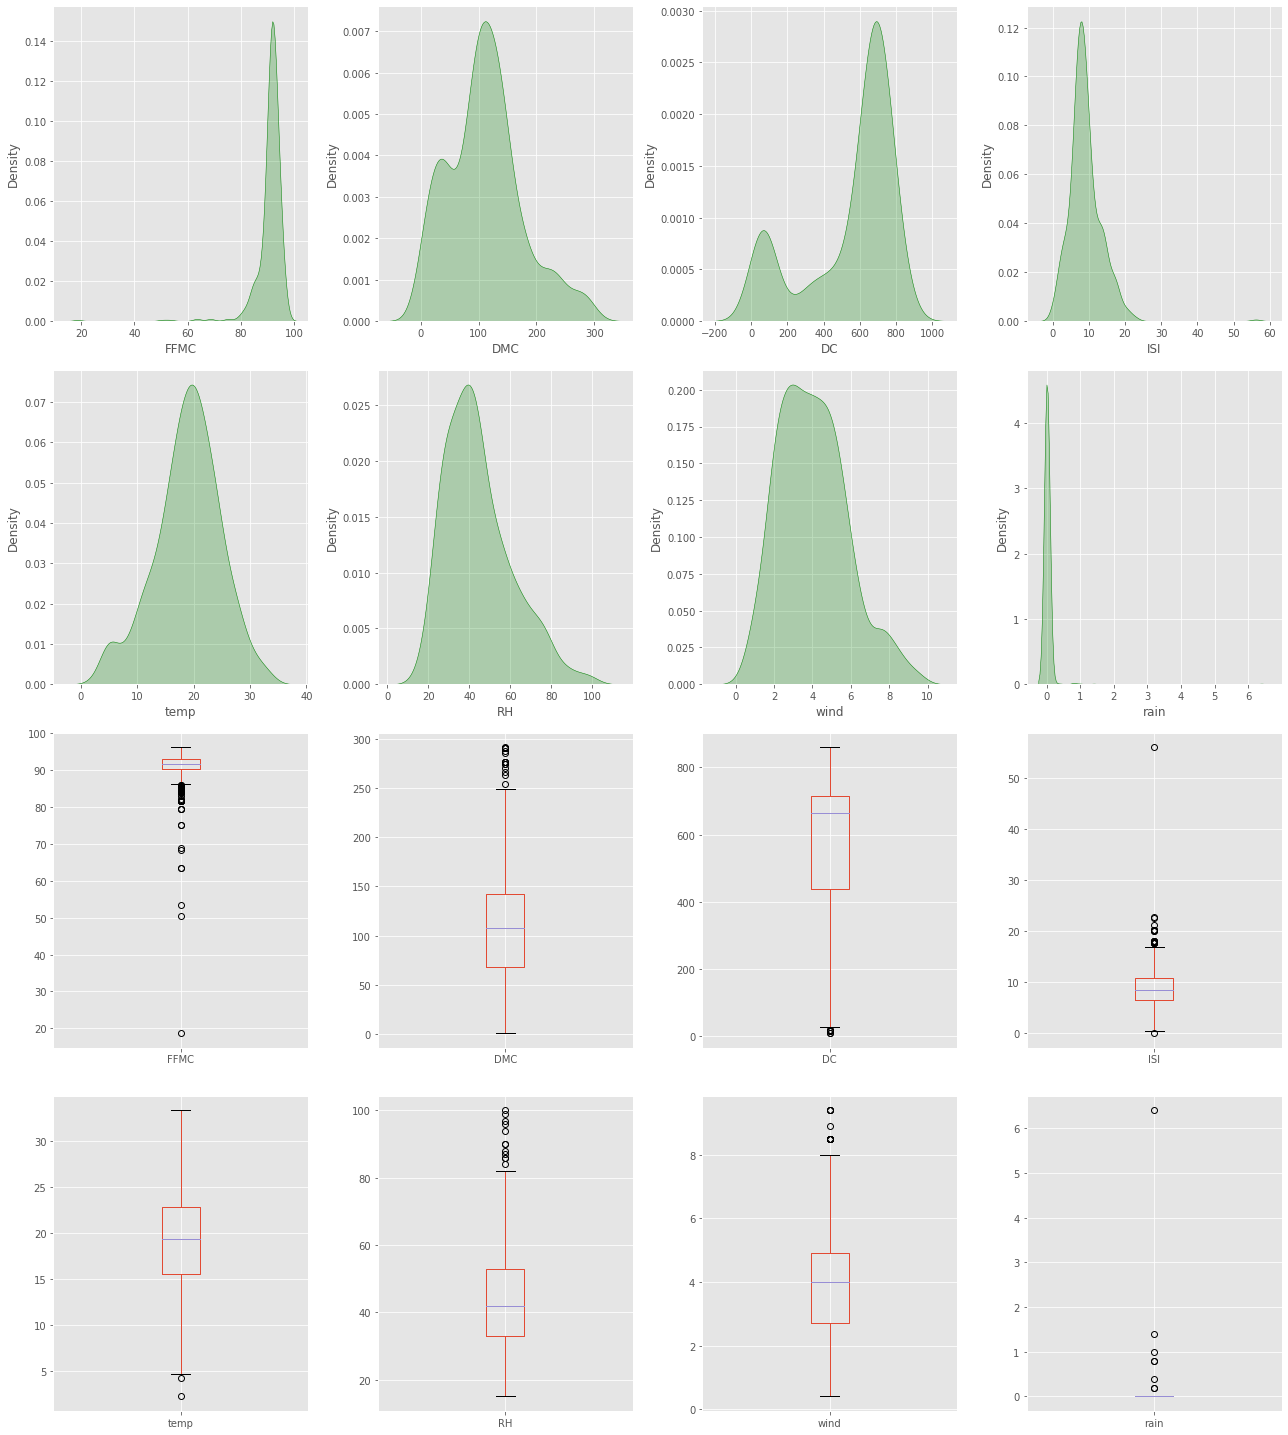

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
skewness,-6.575606,0.547498,-1.100445,2.536325,-0.331172,0.862904,0.571001,19.816344
kurtosis,67.066041,0.204822,-0.245244,21.458037,0.136166,0.438183,0.054324,421.295964


In [14]:
#### Numerical Columns
plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(df[col],color='g',shade=True)
    plt.subplot(8,4,i+8)
    df[col].plot.box()
plt.tight_layout() 
plt.show()
num_data = df[num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

Skew is the degree of distortion from a normal distribution. skewed, meaning there are a minority of very large values.

Kurtosis is all about the tails of the distribution — not the peakedness or flatness. It is used to describe the extreme values in one versus the other tail. It is actually the measure of outliers present in the distribution . High kurtosis in a data set is an indicator that data has heavy tails or outliers.

If skewness is positive, the data are positively skewed or skewed right, meaning that the right tail of the distribution is longer than the left. If skewness is negative, the data are negatively skewed or skewed left, meaning that the left tail is longer.

- If skewness is less than −1 or greater than +1, the distribution is highly skewed.
- If skewness is between −1 and −½ or between +½ and +1, the distribution is moderately skewed.
- If skewness is between −½ and +½, the distribution is approximately symmetric.


- A normal distribution has kurtosis exactly 3 (excess kurtosis exactly 0). Any distribution with kurtosis ≈3 (excess ≈0) is called mesokurtic.
- A distribution with kurtosis <3 (excess kurtosis <0 ) is called platykurtic. Compared to a normal distribution, its tails are shorter and thinner, and often its central peak is lower and broader.
- A distribution with kurtosis >3 (excess kurtosis >0) is called leptokurtic. Compared to a normal distribution, its tails are longer and fatter, and often its central peak is higher and sharper.

**Feature columns:- 'ISI', & 'rain' have +ve skewness, value more than +1 so, they are right skewed.**

**Feature columns:- 'FFMC', & 'temp' have -ve skewness, value less than -1 so, they are left skewed.**

**Feature columns:- 'FFMC', 'ISI', & 'rain' have higher kurtosis value. i,e have outliers.**

Feature columns with (high, +ve, or -ve) outliers, skewness and kurtosis are:

1. FFMC
2. ISI
3. rain

#### Bivariate analysis with our target variable

In [15]:
print(df['area'].describe(),'\n')
print(y_outliers)

count     517.000000
mean       12.847292
std        63.655818
min         0.000000
25%         0.000000
50%         0.520000
75%         6.570000
max      1090.840000
Name: area, dtype: float64 

     FFMC    DMC     DC   ISI  temp  RH  wind  rain     area
237  91.0  129.5  692.6   7.0  18.8  40   2.2   0.0   212.88
238  92.5  121.1  674.4   8.6  25.1  27   4.0   0.0  1090.84
415  94.8  222.4  698.6  13.9  27.5  27   4.9   0.0   746.28
479  89.2  103.9  431.6   6.4  22.6  57   4.9   0.0   278.53


In [16]:
# a categorical variable based on forest fire area damage
# No damage, low, moderate, high, very high
def area_cat(area):
    if area == 0.0:
        return "No damage"
    elif area <= 1:
        return "low"
    elif area <= 25:
        return "moderate"
    elif area <= 100:
        return "high"
    else:
        return "very high"

df['damage_category'] = df['area'].apply(area_cat)
df.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,damage_category
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,No damage
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,No damage
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,No damage
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,No damage
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,No damage


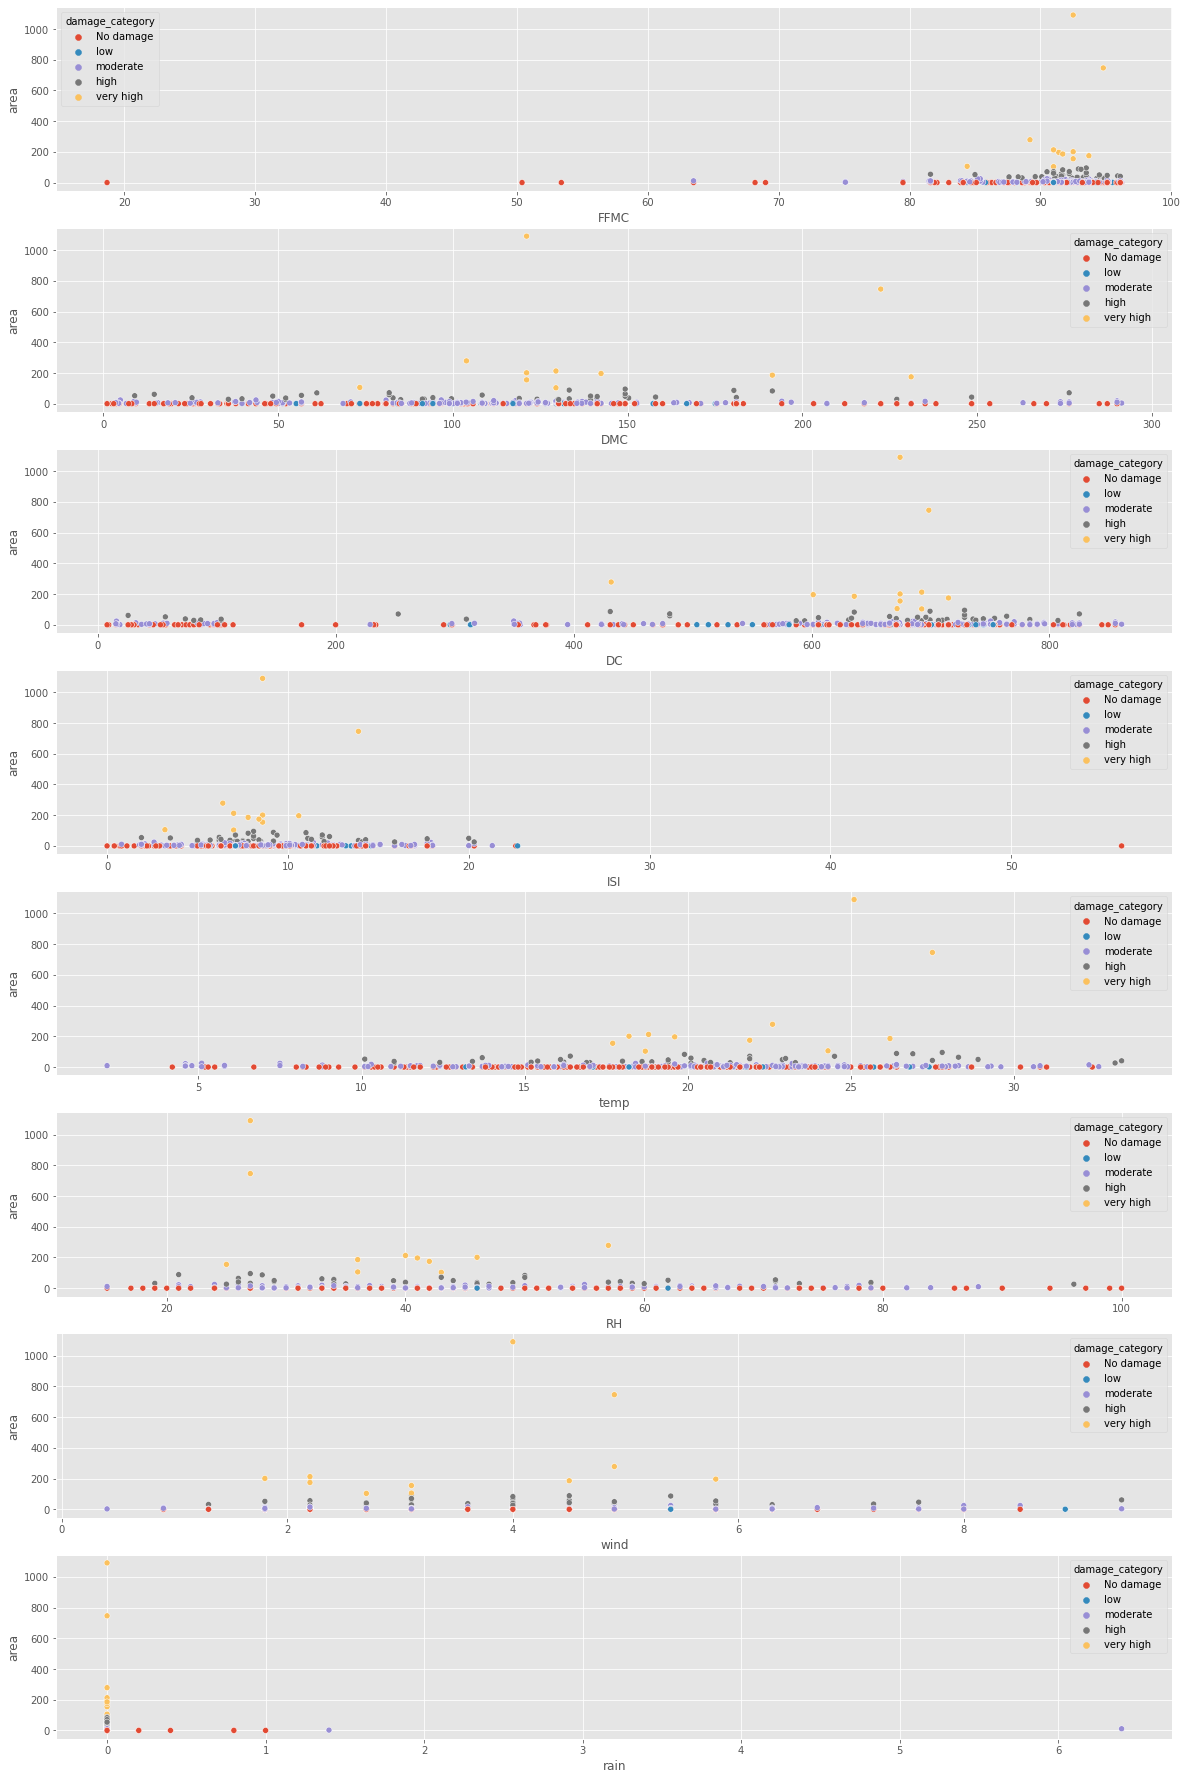

In [17]:
plt.figure(figsize=(20,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(10,1,i)
    if col in ['X','Y']:
        sns.swarmplot(data=df,x=col,y=target,hue='damage_category')
    else:
        sns.scatterplot(data=df,x=col,y=target,hue='damage_category')
plt.show()

In [18]:
selected_features = df.drop(columns=['damage_category']).columns
selected_features

Index(['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area'], dtype='object')

/home/thedhruvrawat/anaconda3/envs/dl/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/thedhruvrawat/anaconda3/envs/dl/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/thedhruvrawat/anaconda3/envs/dl/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/thedhruvrawat/anaconda3/envs/dl/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


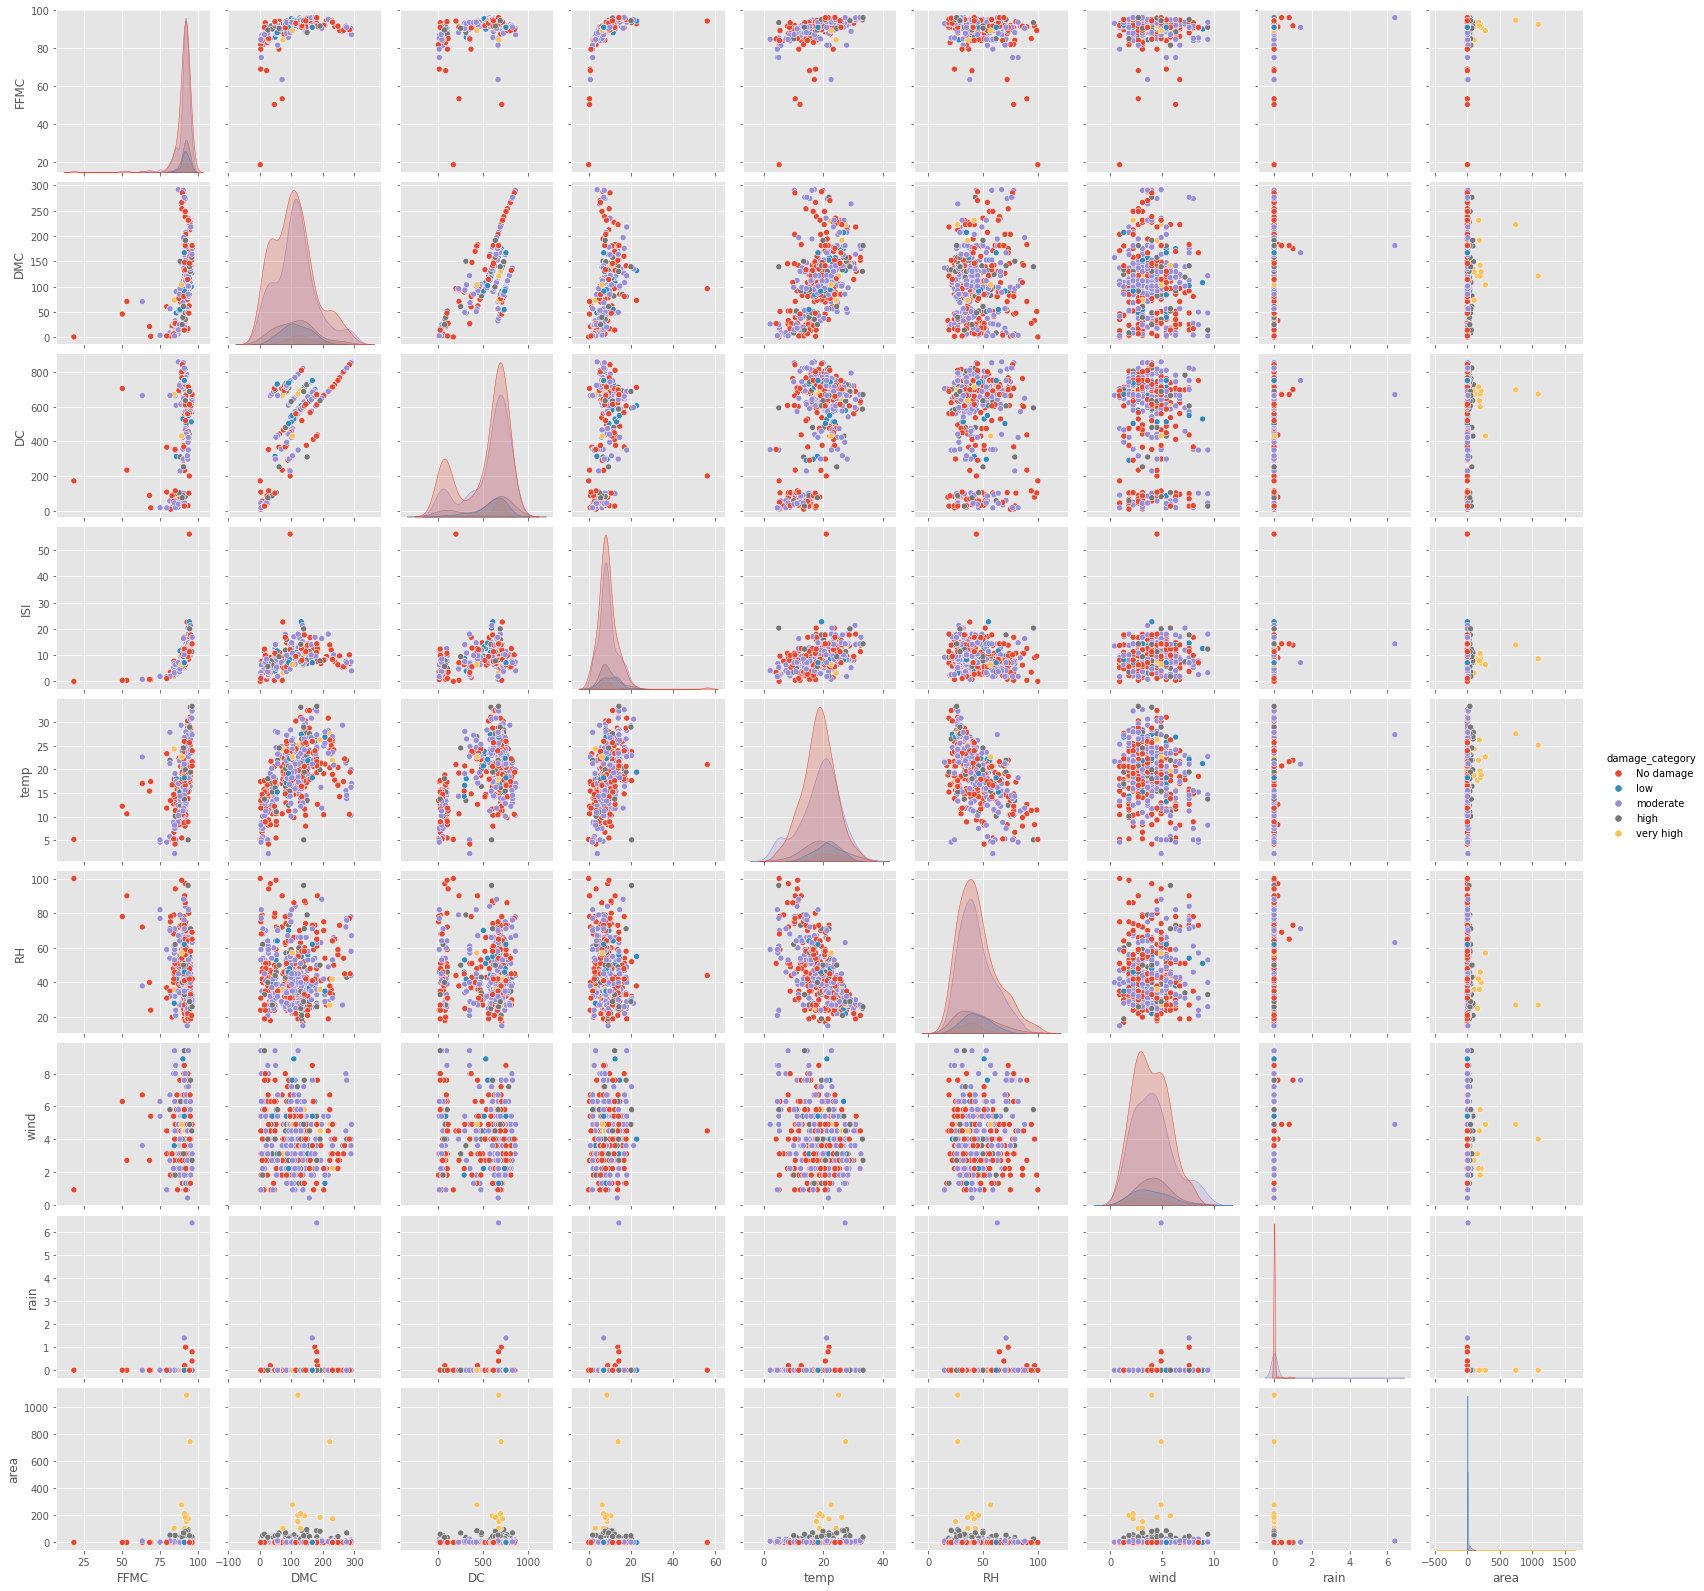

In [19]:
sns.pairplot(df,hue='damage_category',vars=selected_features)
plt.show()

#### Outlier treatment

We had observed outliers in the following columns:

1. area
2. FFMC
3. ISI
4. rain

In [20]:
out_columns = ['area','FFMC','ISI','rain']

However, the above outliers are not error values so we cannot remove it.

In order to minimize the effect of outliers in our model we will transform the above features.

Ref: https://humansofdata.atlan.com/2018/03/when-delete-outliers-dataset/

### Preparing the data for modelling

In [21]:
#Data transformations like log,root,inverse,exponential,etc
print(df[out_columns].describe())
np.log1p(df[out_columns]).skew(), np.log1p(df[out_columns]).kurtosis()

              area        FFMC         ISI        rain
count   517.000000  517.000000  517.000000  517.000000
mean     12.847292   90.644681    9.021663    0.021663
std      63.655818    5.520111    4.559477    0.295959
min       0.000000   18.700000    0.000000    0.000000
25%       0.000000   90.200000    6.500000    0.000000
50%       0.520000   91.600000    8.400000    0.000000
75%       6.570000   92.900000   10.800000    0.000000
max    1090.840000   96.200000   56.100000    6.400000


(area     1.217838
 FFMC   -11.675394
 ISI     -0.937218
 rain    14.173028
 dtype: float64,
 area      0.945668
 FFMC    185.482383
 ISI       2.584588
 rain    234.240025
 dtype: float64)

In [22]:
# FFMC and rain are still having high skew and kurtosis values, 
# since we will be using Linear regression model we cannot operate with such high values
# so for FFMC we can remove the outliers in them using z-score method
mask = df.loc[:,['FFMC']].apply(zscore).abs() < 3

# Since most of the values in rain are 0.0, we can convert it as a categorical column
df['rain'] = df['rain'].apply(lambda x: int(x > 0.0))

df = df[mask.values]
df.shape

(510, 10)

In [23]:
out_columns.remove('rain')
df[out_columns] = np.log1p(df[out_columns])

In [24]:
df[out_columns].skew()

area    1.208492
FFMC   -1.803993
ISI    -0.434372
dtype: float64

In [25]:
# we will use this dataframe for building our ML model
df_ml = df.drop(columns=['damage_category']).copy()

## Linear Regression

__Difference between statistical and machine learning approach__

- Machine learning produces predictions. As far as I can tell, it is not very good at drawing conclusions about general principles based on a set of observations.

- Statistical estimation lets the practitioner make inferences (conclusions about a larger set of phenomena based on the observation of a smaller set of phenomena.) For example, in a regression model the practitioner can estimate the effect of a one unit change in an independent variable X on a dependent variable y.

In [26]:
X = df.drop(columns=['area','damage_category'])
y = df['area']

### Statistical approach

Checking assumptions for linear regression in statistics

1. Linearity of model

2. Normality of residuals

3. Homoscedasticity

4. No Autocorrelation

5. Multicollinearity

In [27]:
X_constant = sm.add_constant(X)

# Build OLS model
lin_reg = sm.OLS(y,X_constant).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.496
Date:                Wed, 21 Apr 2021   Prob (F-statistic):              0.156
Time:                        21:32:04   Log-Likelihood:                -889.26
No. Observations:                 510   AIC:                             1797.
Df Residuals:                     501   BIC:                             1835.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1977     16.702      0.491      0.624     -24.616      41.011
FFMC          -1.6364      3.797     -0.431      0.667      -9.096       5.823
DMC            0.0014      0.001      0.961      0.337      -0.001       0.004
DC             0.0003      0.000      0.810      0.418      -0.000       0.001
ISI           -0.1900      0.276     -0.689      0.491      -0.732       0.352
temp           0.0115      0.018      0.659      0.510      -0.023       0.046
RH            -0.0029      0.005     -0.527      0.599      -0.014       0.008
wind           0.0857      0.038      2.264      0.024       0.011       0.160
rain          -0.7170      0.532     -1.348      0.178      -1.762       0.328
==============================================================================
Omnibus:                       86.849   Durbin-Watson:                   0.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.635
Skew:                           1.162   Prob(JB):                     1.17e-28
Kurtosis:                       3.810   Cond. No.                     1.71e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- __`coef`__: These are the estimates of the factor coefficients. Oftentimes it would not make sense to consider the interpretation of the intercept term. For example, the DC coef suggests that for each additional unit increase in index, we can expect a 0.0014 hectare increase in median value of area, __all other factors remaining the same__.  

- __`P>|t|`__: This is a two tailed hypothesis test where the null hypothesis is that independent variable has no effect on dependent variable. For example, Since the p-value is so low it is approximately zero, then there is strong statistical evidence to reject the claim that `wind` has no effect on `area`.

- __`R-squared`__: This is the amount of variance explained by the model and is often considered to be a measure of how well it fits. However, this factor can be thrown off as it can be artificially inflated by increasing the number of factors even if they are not significant. For this reason we must also considere the __`adjusted R-squared`__ which adjusts calculations to suit the number of factors.

- __`Prob(F-statistic)`__: is the p-value associated with the test of the significance of the overall model. In this case the null hypothesis is that the model is not overall significant. Since our value is way above 0.01, we can not reject the null hypothesis in favour of the alternative, that the model is statistically significant.

### 1. Linearity of residuals

Linearity can be measured by two methods:

- Plot the `observed values Vs predicted values` and plot the `Residual Vs predicted values` and see the linearity of residuals.
- Rainbow test

#### Rainbow Test

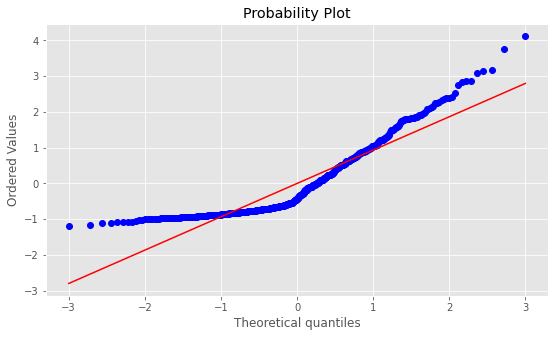

In [28]:
import scipy.stats as stats
import pylab

# get an instance of Influence with influence and outlier measures 
st_resid = lin_reg.get_influence().resid_studentized_internal
stats.probplot(st_resid,dist="norm",plot=pylab)
plt.show()

- __Null hypothesis (H0)__: The Null hypothesis is that the regression is correctly modeled as linear.
- __Alternate hypothesis(H1)__: The model is non-linear

In [29]:
# return fstat and p-value
sm.stats.diagnostic.linear_rainbow(lin_reg)

(1.0313564775199624, 0.4039005475992023)

__Expectation Mean of residual is zero__

In [30]:
# The mean expected value around 0, it implies linearity is preserved
lin_reg.resid.mean()

-6.286213379901122e-14

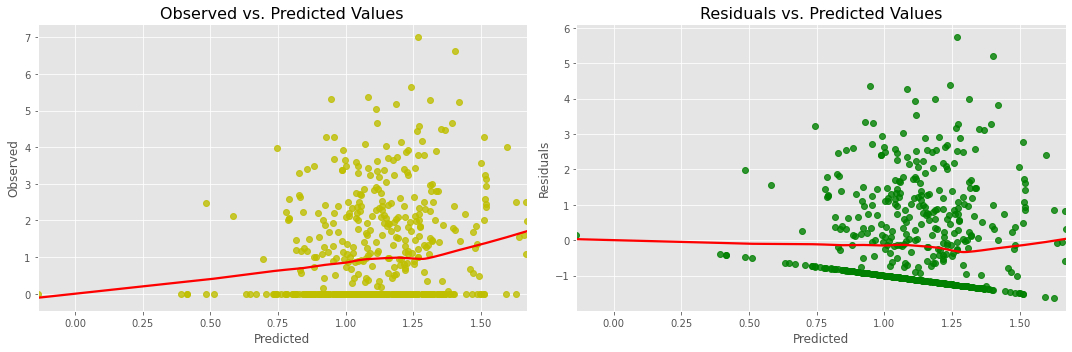

In [31]:
def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2,figsize=(15,5))

    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], color='y', line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], color='g', line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')
    
linearity_test(lin_reg, y) 
plt.tight_layout()

The desired outcome of plots is that points are symmetrically distributed around a diagonal line in the former plot or around horizontal line in the latter one.

- By observing the plots the linearity assumption is not there
- Adding new features might result in linearity of model
- Also, transforming the feature from non-linear to linear using various data transformation techniques can help.

### 2. Normality of the residuals

/home/thedhruvrawat/anaconda3/envs/dl/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


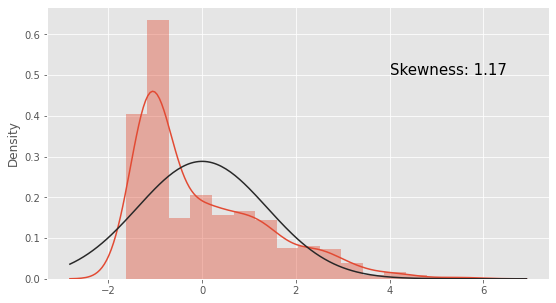

In [32]:
sns.distplot(lin_reg.resid,fit=stats.norm)
plt.text(4,0.5,f"Skewness: {round(lin_reg.resid.skew(),2)}",fontsize=15)
plt.show()

__Test for normality: Jarque Bera__

For a good model, the residuals should be normally distributed. The higher the value of Jarque Bera test, the lesser the residuals are normally distributed.

The __Jarque–Bera test__ is a goodness-of-fit test of whether sample data have the skewness and kurtosis matching a normal distribution.

#### Jarque-Bera (JB): 128.635

The jarque bera test tests whether the sample data has the skewness and kurtosis matching a normal distribution.

Note that this test generally works good for large enough number of data samples(>2000) as the test statistics asymptotically has a chi squared distribution with degrees 2 of freedom.

#### Our dataframe length, 517

Null hypothesis (H0) - Residuals are normally distributed

/home/thedhruvrawat/anaconda3/envs/dl/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


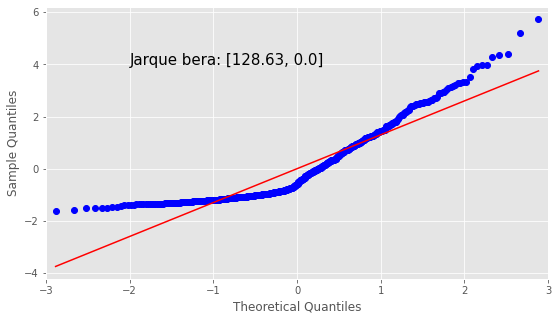

In [33]:
sm.qqplot(lin_reg.resid,line ='r')
jb = [round(n,2) for n in stats.jarque_bera(lin_reg.resid)]
plt.text(-2,4,f"Jarque bera: {jb}",fontsize=15)
plt.show()

The p-value is 0 which simply means we can reject out NULL hypothesis. We can fix that by

- Removing the outliers in the data
- Fixing the Non-linearity in our dependent or target feature
- Removing the bias, the bias might be contributing to the non-normality.

### 3. Homoscedasticity

Homoscedacity: If the residuals are symmetrically distributed across the trend , then it is called as homoscedacious.

Heteroscedacity: If the residuals are not symmetric across the trend, then it is called as heteroscedacious.

__Goldfeld-Quandt test for Homoscedasticity__

H0 = constant variance among residuals (Homoscedacity)

Ha = Heteroscedacity.

In [34]:
sms.het_goldfeldquandt(lin_reg.resid, lin_reg.model.exog)

(0.8823294168227164, 0.8365669539561867, 'increasing')

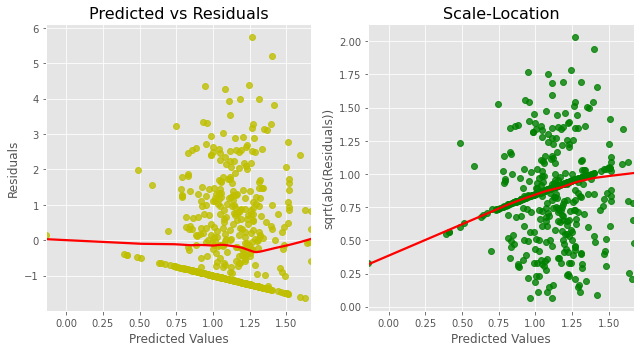

In [35]:
model = lin_reg
fitted_vals = model.predict()
resids = model.resid
resids_standardized = model.get_influence().resid_studentized_internal

fig, ax = plt.subplots(1,2)

sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], color='y', line_kws={'color': 'red'})
ax[0].set_title('Predicted vs Residuals', fontsize=16)
ax[0].set(xlabel='Predicted Values', ylabel='Residuals')

sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], color='g', line_kws={'color': 'red'})
ax[1].set_title('Scale-Location', fontsize=16)
ax[1].set(xlabel='Predicted Values', ylabel='sqrt(abs(Residuals))')

name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model.resid, model.model.exog)
lzip(name, test)
plt.tight_layout()

- To identify homoscedasticity in the plots, the placement of the points should be equally distributed, random, no pattern (increase/decrease in values of residuals) should be visible and a flat red line.
- In the plots we can see there are no paticular patterns and P-Values is also greater than 0.05 ,so we can say that there is homoscedasticity.
- Outliers can make it Heteroscedacious, Transforming (log or Box cox, if > 0) the dependent or independent variables can help fix it.

### 4. No Autocorrelation

Autocorrelation measures the relationship between a variable's current value and its past values.

__Test for autocorrelation : Durbin- Watson Test__

It's test statistic value ranges from 0-4. If the value is between

- 0-2, it's known as Positive Autocorrelation.
- 2-4, it is known as Negative autocorrelation.
- exactly 2, it means No Autocorrelation.

For a good linear model, it should have low or no autocorrelation.

In [36]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(lin_reg.resid)

0.9254462028707562

/home/thedhruvrawat/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


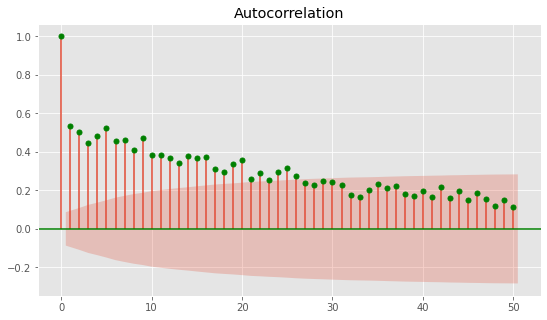

In [37]:
import statsmodels.tsa.api as smt
# Confidence intervals are drawn as a cone. 
# By default, this is set to a 95% confidence interval, 
# suggesting that correlation values outside of this code are very likely a correlation 
# and not a statistical fluke
acf = smt.graphics.plot_acf(lin_reg.resid, color='g', lags=50 , alpha=0.05)
acf.show()

- By observing the above data we can say that there is positive autocorrelation is present , we can reduce it by using fine tuning our parameters
- We can even use Generalize Least Squares (GLS) model

### 5. Multicollinearity

Multicollineariy arises when one independent variable can be linearly predicted by others with a substantial level of accuracy.

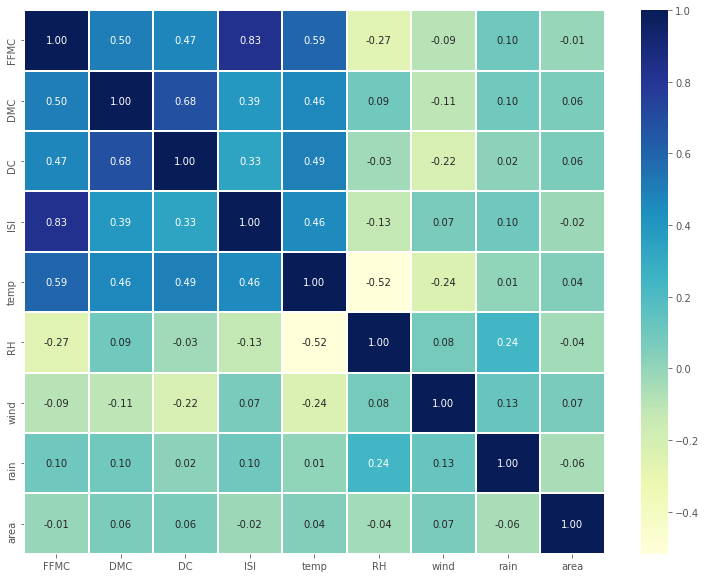

In [38]:
plt.figure(figsize =(13,10))

sns.heatmap(df.corr(),annot=True,cmap='YlGnBu',linewidth = 0.05,fmt=".2f",cbar=True)
plt.show()

As we can see in this heatmap, The lighter color shows the higher cor-relation betweem two variables and the darker color has less relation ship.

In [39]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X.columns).sort_values(by="vif",ascending=False)

,vif
FFMC,4.606915
ISI,3.648357
temp,2.685161
DMC,2.356048
DC,2.115299
RH,1.980695
wind,1.196414
rain,1.142489


There is multicollinearity present between some features where vif >5.

- We can even use PCA to reduce features to a smaller set of uncorrelated components.
- To deal with multicollinearity we should iteratively remove features with high values of VIF.

### Machine Learning Approach

In [40]:
reg = LinearRegression()
reg.fit(X, y)

print(f'Intercept: {reg.intercept_}')
print(f'R^2 score: {reg.score(X, y)}')
pd.DataFrame({"Coefficients": reg.coef_}, index=X.columns)

Intercept: 8.197657535441701
R^2 score: 0.023324191155653318


,Coefficients
FFMC,-1.636369
DMC,0.001429
DC,0.000296
ISI,-0.190013
temp,0.011547
RH,-0.002873
wind,0.085676
rain,-0.717001


### Improving Statistical Accuracy

#### Dropping columns to improve accuracy:

By checking high Variance inflation factor and p-value we will decide whether to keep the column or drop it.

R^2 = 1 - SSE(Sum of Square of Residuals)/SST (Sum of square Total)

Just by dropping constant we got a huge bump in adjusted R2 from 2.3% to 40.5%.

In [41]:
X = df.drop(columns=['area','damage_category'])
y = df['area']

In [42]:
def check_stats(X,y):
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(pd.DataFrame({'vif': vif}, index=X.columns).sort_values(by="vif",ascending=False)[:10])
    lin_reg = sm.OLS(y,X).fit()
    print(lin_reg.summary())
check_stats(X,y)

            vif
FFMC  76.537648
ISI   40.782391
temp  31.421411
RH    15.790602
DC    12.442715
DMC    9.206680
wind   6.990295
rain   1.137133
                                 OLS Regression Results                                
Dep. Variable:                   area   R-squared (uncentered):                   0.405
Model:                            OLS   Adj. R-squared (uncentered):              0.395
Method:                 Least Squares   F-statistic:                              42.66
Date:                Wed, 21 Apr 2021   Prob (F-statistic):                    5.19e-52
Time:                        21:32:06   Log-Likelihood:                         -889.38
No. Observations:                 510   AIC:                                      1795.
Df Residuals:                     502   BIC:                                      1829.
Df Model:                           8                                                  
Covariance Type:            nonrobust                           

In [43]:
X.drop(columns=['temp'],inplace=True)
check_stats(X,y)

            vif
FFMC  50.658079
ISI   37.726196
DC    11.941201
RH     9.630328
DMC    8.385840
wind   6.611032
rain   1.110165
                                 OLS Regression Results                                
Dep. Variable:                   area   R-squared (uncentered):                   0.404
Model:                            OLS   Adj. R-squared (uncentered):              0.396
Method:                 Least Squares   F-statistic:                              48.76
Date:                Wed, 21 Apr 2021   Prob (F-statistic):                    8.71e-53
Time:                        21:32:06   Log-Likelihood:                         -889.59
No. Observations:                 510   AIC:                                      1793.
Df Residuals:                     503   BIC:                                      1823.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                           

Similarly, you can continue to optimize the model.

Our Prob (F-statistic) has improved from 0.156 to 8.71e-53. As the value is less than 0.05, the model becomes more significant.